<a href="https://colab.research.google.com/github/beatrizjafelice/Airline-Passenger-Satisfaction/blob/master/Airline_Passenger_Satisfaction_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade
1.   Baixar uma base de dados referente a um assunto de interesse seu.
2.   Configurar o pré-processamento adequado
3.   Comparar o desempenho de no mínimo 2 classificadores (pelo menos 1 único e 1 ensemble)
4.   Investigar variações de parâmetros (pelo menos 2 valores de cada um)
5.   Reportar os resultados

## Carregando os dados

O dataset escolhido é o [Airline Passenger Satisfaction](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction), disponível no Kaggle. Os datasets de treino e teste são disponibilizados separadamente. O dataset é composto de 25 colunas, entre elas:
- Informações básicas sobre os passageiros (idade, gênero e se o passageiro é um cliente "fiel" ou não);
- Algumas colunas com informações sobre a viagem (como tipo de viagem, classe, distância do voo e tempo de atraso na chegada e na partida);
- Colunas com avaliações de 1 a 5 para diversos aspectos da viagem;
- Uma variável target indicando a satisfação do passageiro com a viagem, tomando dois valores possíveis: "neutral or dissatisfied" ou "satisfied". <br>

<br>


**Metadados retirados da documentação:**

Gender: Gênero dos passageiros (Feminino, Masculino)

Customer Type: O tipo de cliente (Cliente fiel ou não)

Age: A idade real dos passageiros

Type of Travel: Propósito da viagem (Viagem pessoal, Viagem a negócios)

Class: Classe de viagem (Executiva, Econômica, Econômica Plus)

Flight distance: A distância do voo na viagem

Inflight wifi service: Nível de satisfação com o serviço de wifi a bordo (0: Não Aplicável; 1-5)

Departure/Arrival time convenient: Nível de satisfação com a conveniência do horário de partida/chegada

Ease of Online booking: Nível de satisfação com a facilidade de reserva online

Gate location: Nível de satisfação com a localização do portão de embarque

Food and drink: Nível de satisfação com a comida e bebida

Online boarding: Nível de satisfação com o embarque online

Seat comfort: Nível de satisfação com o conforto do assento

Inflight entertainment: Nível de satisfação com o entretenimento a bordo

On-board service: Nível de satisfação com o serviço de bordo

Leg room service: Nível de satisfação com o espaço para as pernas

Baggage handling: Nível de satisfação com o manuseio de bagagens

Check-in service: Nível de satisfação com o serviço de check-in

Inflight service: Nível de satisfação com o serviço de bordo

Cleanliness: Nível de satisfação com a limpeza

Departure Delay in Minutes: Minutos de atraso na partida

Arrival Delay in Minutes: Minutos de atraso na chegada

Satisfaction: Nível de satisfação com a companhia aérea (Satisfeito, neutro ou insatisfeito) <br>

<br>

Logo, trata-se de um problema de classificação binária, cuja variável target será a satisfação do passageiro (satisfied/neutral or dissatisfied). Nesta atividade, serão testados dois modelos únicos de classificação (Regressão Logística e kNN) e dois métodos ensemble (XGBoost e Random Forest) - todos treinados após o ajuste de parâmetros. Ao final, serão comparados os desempenhos dos diferentes modelos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import cv
from xgboost import XGBClassifier

In [ ]:
df_train = pd.read_csv('https://drive.google.com/u/3/uc?id=1pSDMxwSWk-3gGS39ElgMPSefr0mHKEk5&export=download', index_col='Unnamed: 0')
df_test = pd.read_csv('https://drive.google.com/u/3/uc?id=1t7GDVfkMDAC7Qhpbbm83FtZBKAr7exBD&export=download', index_col='Unnamed: 0')

In [ ]:
print(df_train.shape)
print(df_test.shape)

(103904, 24)
(25976, 24)


In [ ]:
# Unindo o dataset
df = pd.concat([df_train, df_test])
print(df.shape)
df.head()

(129880, 24)


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Análise Exploratória

In [ ]:
df.dtypes

id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival De

In [ ]:
df.describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,64940.500000,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,37493.270818,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32470.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64940.500000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97410.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


Verificando a existência de valores nulos:

In [ ]:
df.isnull().sum()

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
satisfaction                           0
dtype: int64

Observa-se que a coluna "Arrival Delay in Minutes" possui alguns valores faltantes. Prosseguiremos com a análise para verificar a melhor forma de lidar com o problema.

Verificando a existência de linhas duplicadas:

In [ ]:
df[df.duplicated()]

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction


Verificando a contagem de observações por rótulo:

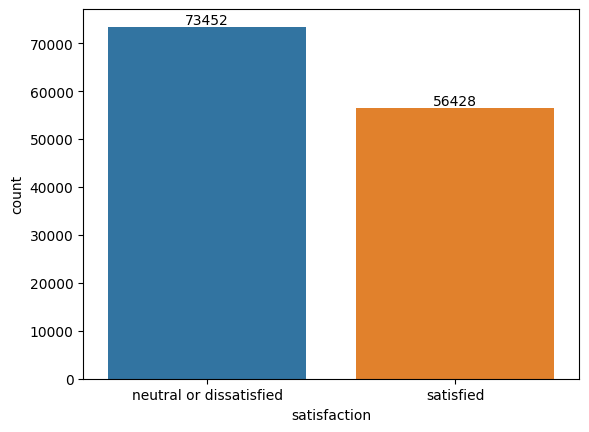

In [ ]:
df_sat = df['satisfaction'].value_counts().to_frame().reset_index()
ax = sns.barplot(x='satisfaction', y='count',
                 hue='satisfaction', data=df_sat)
for i in ax.containers:
    ax.bar_label(i,)

Selecionando as colunas de interesse:

In [ ]:
df.drop(['id', 'Age', 'Gender', 'Flight Distance'], axis = 1, inplace=True)
df.head()

,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Loyal Customer,Personal Travel,Eco Plus,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,disloyal Customer,Business travel,Business,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Loyal Customer,Business travel,Business,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,Loyal Customer,Business travel,Business,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Loyal Customer,Business travel,Business,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


Utilizando um mapa de calor para analisar possíveis correlações entre variáveis:

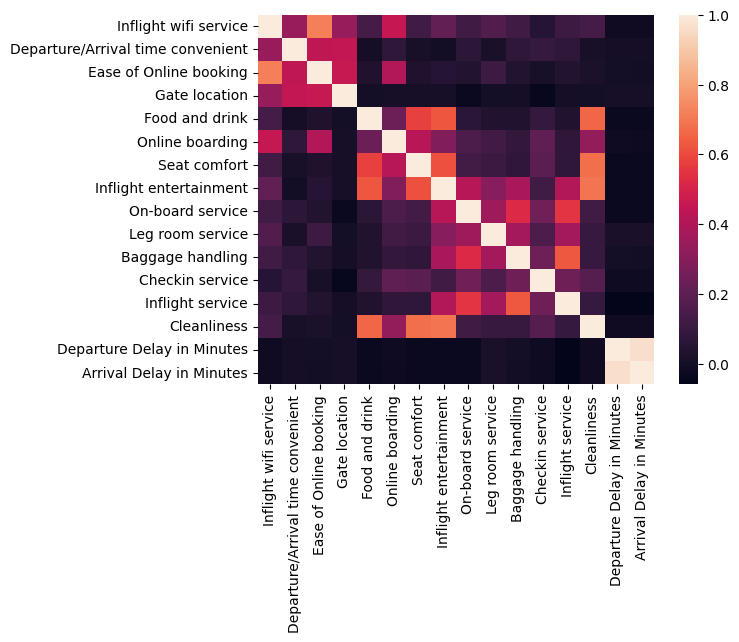

In [ ]:
matriz_corr = df.corr(numeric_only=True)
sns.heatmap(matriz_corr)
plt.show()

Para uma melhor visualização, filtra-se apenas os pares de variáveis com correlação maior que 0,5:

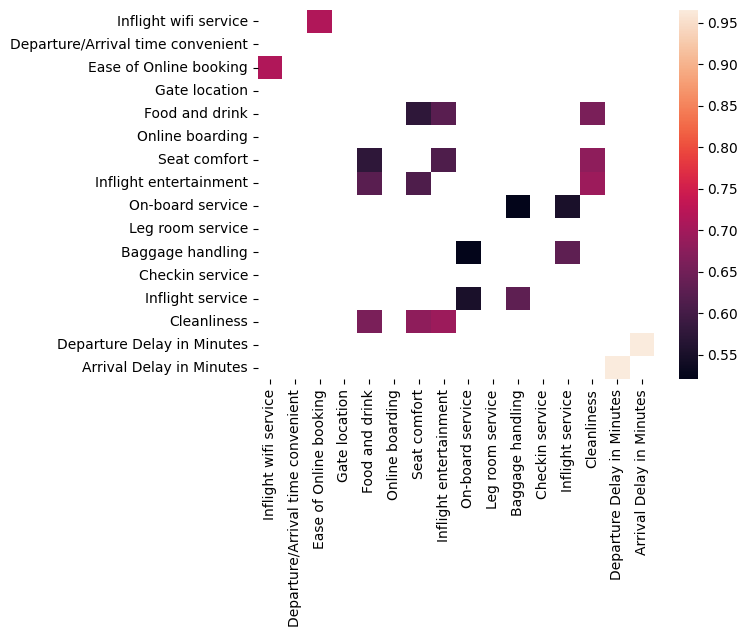

In [ ]:
sns.heatmap(matriz_corr[(matriz_corr > 0.5) & (matriz_corr < 1)])
plt.show()

Observa-se uma correlação fortemente positiva entre os tempos de atraso de partida e chegada. É possível explorar essa correlação com o gráfico abaixo:

0.9652911835463196


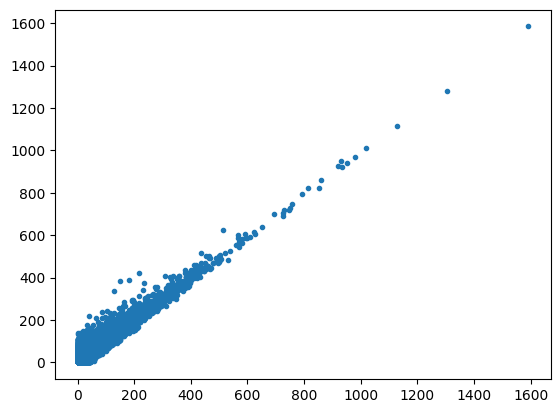

In [ ]:
print(df['Departure Delay in Minutes'].corr(df['Arrival Delay in Minutes']))
plt.plot(df['Departure Delay in Minutes'], df['Arrival Delay in Minutes'], '.')

Agora, verificamos agora a quantidade de valores nulos para cada coluna:

In [ ]:
df[['Arrival Delay in Minutes', 'Departure Delay in Minutes']].isnull().sum()

Arrival Delay in Minutes      393
Departure Delay in Minutes      0
dtype: int64

Como já visto anteriormente, há valores nulos na coluna "Arrival Delay in Minutes". Logo, opta-se por desconsiderar essa coluna.

In [ ]:
df.drop(['Arrival Delay in Minutes'], axis = 1, inplace=True)
df.head()

,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,Loyal Customer,Personal Travel,Eco Plus,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,neutral or dissatisfied
1,disloyal Customer,Business travel,Business,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,neutral or dissatisfied
2,Loyal Customer,Business travel,Business,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,satisfied
3,Loyal Customer,Business travel,Business,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,neutral or dissatisfied
4,Loyal Customer,Business travel,Business,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,satisfied


Analisando graficamente as proporções de cada classe para as variáveis categóricas:

In [ ]:
def mostrarCategorico(df, coluna):
  # Preparando o dataset
  prop = df[coluna].value_counts().to_frame().reset_index().rename(columns={'count': 'total'})
  cat_1 = df.groupby([coluna, 'satisfaction']).agg({'satisfaction': 'count'}).rename(columns={'satisfaction': 'count'}).reset_index()
  qtd = pd.merge(cat_1, prop, on=coluna, how='left')
  qtd['prop'] = round((qtd['count'] / qtd['total'] * 100), 2)
  qtd.drop(['total', 'count'], axis=1, inplace=True)

  # Plotando o gráfico
  plt.figure(figsize=(10, 6))
  palette = sns.color_palette("viridis", 2)
  barplot = sns.barplot(x=coluna, y="prop", hue="satisfaction", data=qtd, palette=palette)
  plt.title(f'{coluna} x Satisfaction')
  plt.ylabel('Proportion (%)')
  plt.xlabel(coluna)
  plt.ylim(0, 100)
  plt.legend(title='Satisfaction')

  # Adicionando rótulos de dados
  for p in barplot.containers:
      barplot.bar_label(p, fmt='%.2f%%', label_type='edge', padding=3)

  plt.show()

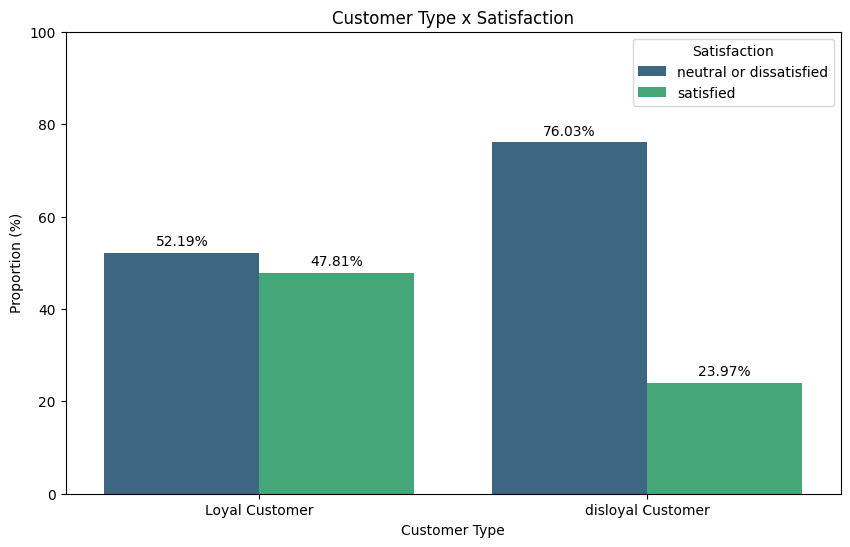

In [ ]:
mostrarCategorico(df, 'Customer Type')

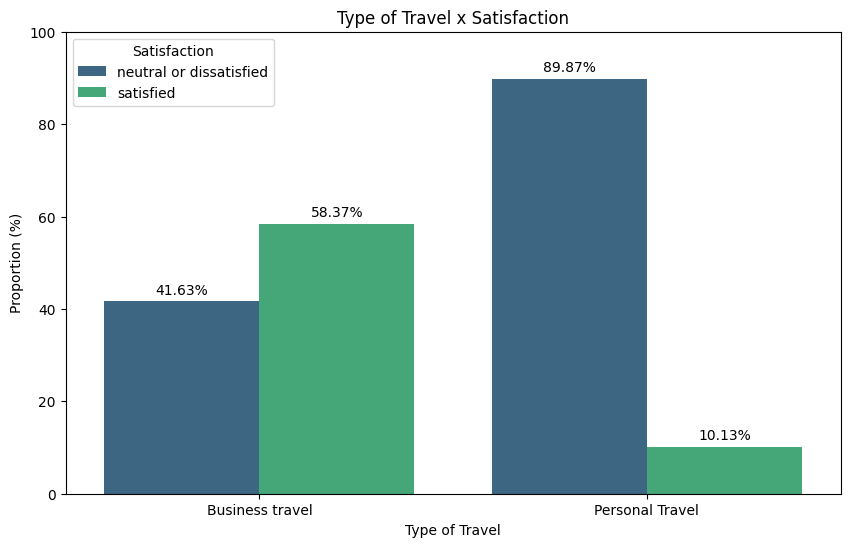

In [ ]:
mostrarCategorico(df, 'Type of Travel')

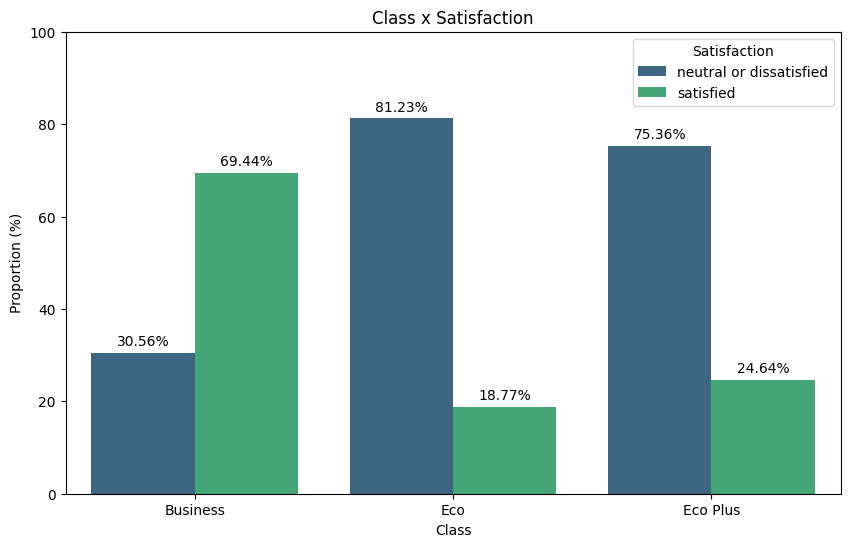

In [ ]:
mostrarCategorico(df, 'Class')

## Pré-processamento

Transformando as variáveis categóricas:

In [ ]:
df['satisfied'] = np.where(df['satisfaction'] == 'satisfied', 1, 0)
df.drop('satisfaction', axis=1, inplace=True)
df.head()

,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfied
0,Loyal Customer,Personal Travel,Eco Plus,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0
1,disloyal Customer,Business travel,Business,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,0
2,Loyal Customer,Business travel,Business,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1
3,Loyal Customer,Business travel,Business,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,0
4,Loyal Customer,Business travel,Business,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1


In [ ]:
df['Loyal Customer'] = np.where(df['Customer Type'] == 'Loyal Customer', 1, 0)
df['Business Travel'] = np.where(df['Type of Travel'] == 'Business travel', 1, 0)
df.drop(['Customer Type', 'Type of Travel'], axis=1, inplace=True)
df.head()

,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfied,Loyal Customer,Business Travel
0,Eco Plus,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0,1,0
1,Business,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,0,0,1
2,Business,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1,1,1
3,Business,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,0,1,1
4,Business,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1,1,1


In [ ]:
class_dummies = pd.get_dummies(df['Class'], drop_first = True)
df = df.drop('Class', axis=1)
df = df.assign(**class_dummies)
df.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfied,Loyal Customer,Business Travel,Eco,Eco Plus
0,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,0,1,0,False,True
1,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,0,0,1,False,False
2,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,1,1,1,False,False
3,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,0,1,1,False,False
4,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,1,1,1,False,False


Separando features e target:

In [ ]:
X = df.drop('satisfied', axis=1).copy()
print(X.shape)
y = df['satisfied'].copy()
print(y.shape)

(129880, 19)
(129880,)


Separando em treino e teste:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

Normalizando os dados:

In [ ]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Modelagem

A função abaixo fornece um resumo da performance de um modelo de classificação nos conjuntos de treino e teste e será utilizada nas próximas etapas.

In [ ]:
def mostrarMetricas(modelo):
  # Métricas de treino
  y_pred_train = modelo.predict(X_train.values)

  # Métricas de teste
  y_pred_test = modelo.predict(X_test.values)

  print("---------------- Métricas de Treino ----------------")
  print(classification_report(y_train, y_pred_train))
  cm = confusion_matrix(y_train, y_pred_train, labels=modelo.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelo.classes_)
  disp.plot()
  plt.title("Matriz de Confusão")
  plt.show()

  print(" ")

  print("---------------- Métricas de Teste ----------------")
  print(classification_report(y_test, y_pred_test))
  cm = confusion_matrix(y_test, y_pred_test, labels=modelo.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelo.classes_)
  disp.plot()
  plt.title("Matriz de Confusão")
  plt.show()

O conjunto de dados será dividido pela técnica de K-Fold Cross Validation. Os folds serão utilizados para otimização de parâmetros por meio do método **GridSearch**. Dado um dicionário com opções de parâmetros, o GridSearch testa todas as diferentes combinações possíveis e retorna aquela que produz o melhor desempenho. Por tratar-se de um método computacionalmente custoso, será testado um número reduzido de parâmetros para demonstração.

In [ ]:
skf = StratifiedKFold(5)
folds = skf.split(X_train, y_train)
folds_list = list(folds)

### Classificadores Únicos

Primeiramente, serão testados dois classificadores únicos comumente utilizados em problemas de aprendizado de máquina: A Regressão Logística e o kNN.

#### Classificador 1: Regressão Logística

O primeiro classificador a ser testado é a Regressão Logística. Trata-se de um método de classificação que modela a probabilidade de um objeto pertencer a uma dada classe. Para isso, a Regressão Logística ajusta uma função sigmoide aos dados, que retorna valores entre 0 e 1. Valores mais próximos de 1 indicam maior probabilidade de pertencer à classe positiva, enquanto valores mais próximos de 0 indicam maior probabilidade de pertencer à classe negativa.

Ajuste de parâmetros:

In [ ]:
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['lbfgs', 'saga'],
    'model__max_iter': [100, 300],
    'model__tol': [1e-3, 1e-5]
}

# Cria a pipeline
clf_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('model', LogisticRegression())])

# Instanciando um objeto de GridSearch para encontrar os melhores parâmetros
lr_search = GridSearchCV(clf_pipe, param_grid, cv=folds_list, scoring=['f1', 'roc_auc'], refit='f1', n_jobs=-1, verbose=False)

# Ajusta o GridSearch aos dados de treinamento
lr_search.fit(X_train.values, y_train)

# Retorna os melhores parâmetros e o melhor score
best_params = lr_search.best_params_
best_score = lr_search.best_score_

print("Melhores parâmetros:", best_params)
print("Melhor score:", best_score)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


Melhores parâmetros: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'saga', 'model__tol': 0.001}
Melhor score: 0.8518557616718303


Treinando e avaliando o modelo com os melhores parâmetros:

---------------- Métricas de Treino ----------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     55089
           1       0.87      0.84      0.85     42321

    accuracy                           0.87     97410
   macro avg       0.87      0.87      0.87     97410
weighted avg       0.87      0.87      0.87     97410



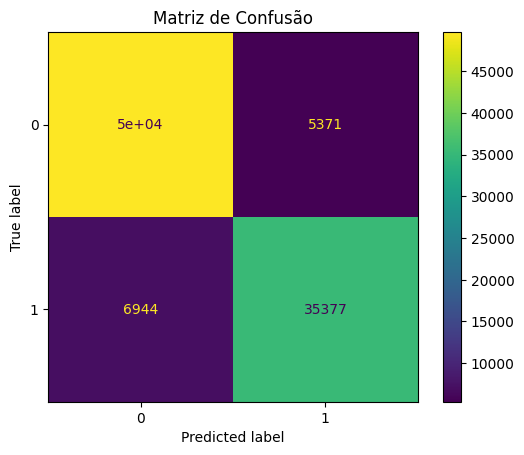

 
---------------- Métricas de Teste ----------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     18363
           1       0.87      0.84      0.85     14107

    accuracy                           0.87     32470
   macro avg       0.87      0.87      0.87     32470
weighted avg       0.87      0.87      0.87     32470



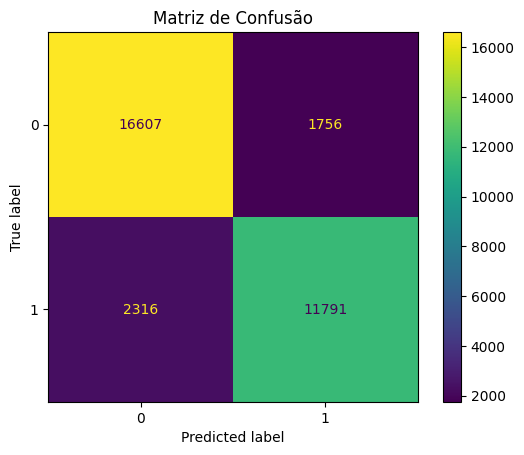

In [ ]:
melhor_modelo = lr_search.best_estimator_
mostrarMetricas(melhor_modelo)

A Regressão Logística apresentou resultados consistentes tanto no conjunto de treino quanto no conjunto de testes, com acurácia e F1-Score iguais a 87%.

#### Classificador 2: kNN

O segundo modelo a ser testado é o kNN (k-Nearest Neighbors). É um algoritmo de aprendizado que pode ser utilizado tanto para classificação quanto para regressão. Na classificação, o kNN estima a classe de um objeto com base na classe majoritária ou mais provável entre os k vizinhos mais próximos daquele ponto. O algoritmo calcula a proximidade entre os pontos utilizando uma métrica de distância, como a distância euclidiana. O valor de k deve ser escolhido com cuidado, pois pode influenciar significativamente o desempenho do modelo. Um valor de k muito pequeno pode tornar o modelo sensível a ruídos, levando ao *overfitting*, enquanto um valor de k muito grande pode gerar um modelo generalista, causando o *underfitting*.

Ajuste de parâmetros:

In [ ]:
param_grid = {
    'model__n_neighbors': [7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'kd_tree']
}

# Cria a pipeline
clf_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('model', KNeighborsClassifier())])

# Faz o grid search com os folds da validação cruzada
knn_search = GridSearchCV(clf_pipe, param_grid=param_grid, cv=folds_list, scoring=['f1', 'roc_auc'], refit='f1', n_jobs=-1)

# Ajusta o grid search aos dados de treinamento
knn_search.fit(X_train, y_train)

# Retorna os melhores parâmetros e score
best_params = knn_search.best_params_
best_score = knn_search.best_score_

print("Melhores parâmetros:", best_params)
print("Melhor score:", best_score)

Melhores parâmetros: {'model__algorithm': 'kd_tree', 'model__n_neighbors': 7, 'model__weights': 'distance'}
Melhor score: 0.919225431320907


Treinando e avaliando o modelo com os melhores parâmetros:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


---------------- Métricas de Treino ----------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55089
           1       1.00      1.00      1.00     42321

    accuracy                           1.00     97410
   macro avg       1.00      1.00      1.00     97410
weighted avg       1.00      1.00      1.00     97410



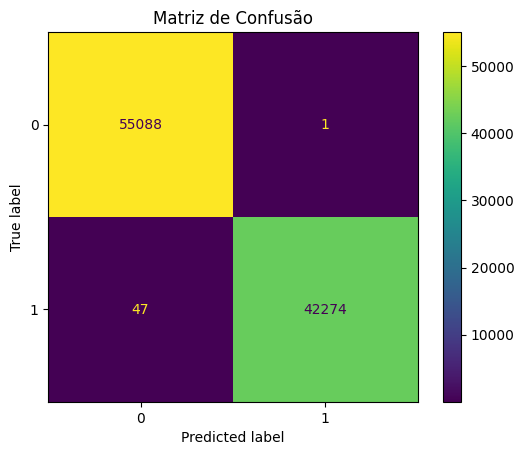

 
---------------- Métricas de Teste ----------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     18363
           1       0.96      0.89      0.92     14107

    accuracy                           0.93     32470
   macro avg       0.94      0.93      0.93     32470
weighted avg       0.93      0.93      0.93     32470



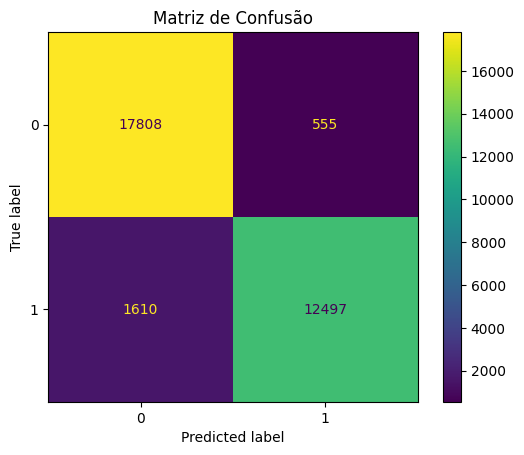

In [ ]:
melhor_modelo = knn_search.best_estimator_
mostrarMetricas(melhor_modelo)

Embora o melhor modelo resultante do GridSearch tenha retornado o menor valor de k, o kNN apresentou métricas perfeitas no conjunto de treino (1.00), indicando *overfitting*. No conjunto de testes, a acurácia e F1-Score caíram para 93%, confirmando que o modelo não generalizou tão bem para dados novos.

### Métodos Ensemble

Em seguida, serão testados dois métodos Ensemble: XGBoost e Random Forest. Os métodos Ensemble combinam diversos preditores 'fracos' para formar um preditor final mais robusto. A performance desses métodos tende a ser melhor do que a de classificadores únicos, pois agregam múltiplas previsões e resultam em modelos mais precisos e estáveis. Isso ocorre porque o Ensemble pode reduzir o risco de *overfitting* e aumentar a capacidade de generalização ao capturar diferentes aspectos dos dados de treinamento. O resultado desses métodos no presente problema será comparado posteriormente aos resultados obtidos com os classificadores únicos.

#### Classificador 3: XGBoost

O primeiro método Ensemble avaliado é o XGBoost. O XGBoost (Extreme Gradient Boosting) é um algoritmo de aprendizado de máquina baseado em árvores de decisão que treina seus preditores de forma sequencial. A cada iteração, o modelo tenta corrigir os erros cometidos pelas árvores anteriores ajustando os resíduos (diferenças entre os valores preditos e reais) do modelo anterior. Isso significa que cada nova árvore construída "aprende" com os erros das árvores anteriores. Além disso, o XGBoost incorpora métodos de regularização (como L1 e L2) para prevenir overfitting e suporta processamento paralelo, otimizando o processo de aprendizado. Essas características fazem do XGBoost um método poderoso e eficiente para problemas de classificação e regressão.

In [ ]:
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.1, 0.01, 0.001],
    'model__n_estimators': [100, 300]
}

# Cria a pipeline
clf_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('model', XGBClassifier())])

# Faz o grid search com validação cruzada
xgb_search = GridSearchCV(clf_pipe, param_grid=param_grid, cv=folds_list, scoring=['f1', 'roc_auc'], refit='f1', n_jobs=-1)

# Ajusta o grid search aos dados de treinamento
xgb_search.fit(X_train, y_train)

# Retorna os melhores parâmetros e score
best_params = xgb_search.best_params_
best_score = xgb_search.best_score_

print("Melhores parâmetros:", best_params)
print("Melhor score:", best_score)

Melhores parâmetros: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
Melhor score: 0.9551114771063409


Treinando e avaliando o modelo com os melhores parâmetros:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


---------------- Métricas de Treino ----------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     55089
           1       0.98      0.96      0.97     42321

    accuracy                           0.97     97410
   macro avg       0.98      0.97      0.97     97410
weighted avg       0.98      0.97      0.97     97410



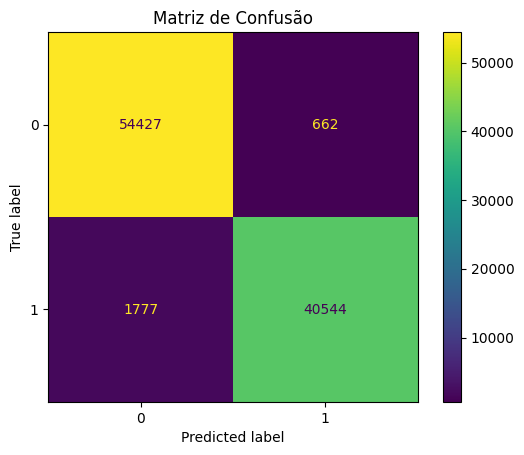

 
---------------- Métricas de Teste ----------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18363
           1       0.97      0.94      0.96     14107

    accuracy                           0.96     32470
   macro avg       0.96      0.96      0.96     32470
weighted avg       0.96      0.96      0.96     32470



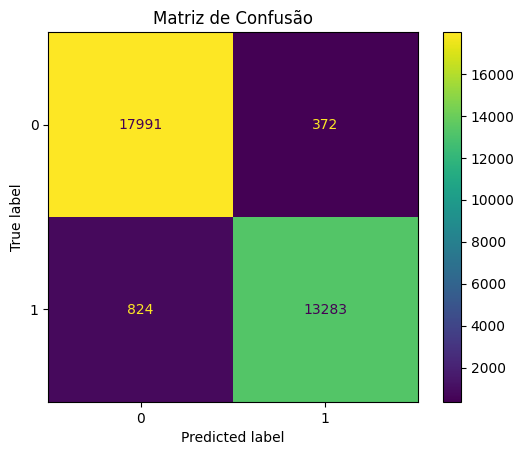

In [ ]:
melhor_modelo = xgb_search.best_estimator_
mostrarMetricas(melhor_modelo)

Verificando a relevância de cada variável (feature importance) na previsão da resposta final.

Text(0.5, 1.0, 'Feature Importance')

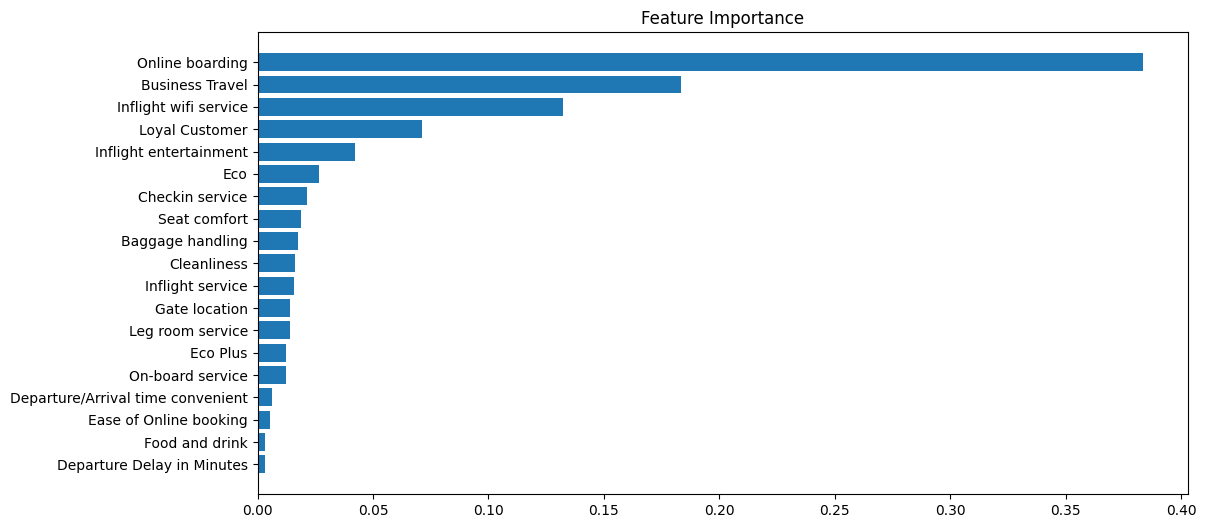

In [ ]:
estimator = melhor_modelo.named_steps['model']
feature_importance = estimator.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

O XGBoost apresentou um F1-Score de 97% no treino e 96% nos testes. Isso mostra um equilíbrio entre a capacidade de ajuste aos dados de treino e a generalização aos dados de teste, mostrando uma leve diferença na performance, o que é esperado. Além disso, como outros métodos Ensemble, é possível analisar a importância de cada feature no processo de decisão. Neste caso, observa-se que Online Boarding, Business Travel e Inflight Wifi Service foram as três principais variáveis consideradas.

#### Classificador 4: Random Forest

O último classificador testado é o Random Forest. Trata-se de um método Ensemble que treina diversas árvores de decisão utilizando amostras selecionadas do conjunto de dados de forma aleatória e com reposição  (*bootstrap*). Além disso, em cada árvore, um subconjunto aleatório de variáveis é considerado para encontrar as melhores divisões para os nós. Essa estratégia ajuda a prevenir o overfitting, promovendo a diversidade entre árvores individuais e evitando que o modelo considere apenas os preditores mais influentes. O número de árvores na floresta (n_estimators) e a profundidade máxima de cada árvore (max_depth) são parâmetros importantes para esse modelo. A classe predita é a classe mais frequente entre os votos das árvores individuais (voto majoritário). Embora seja um método robusto e preciso, pode ser computacionalmente custoso para grandes conjuntos de dados.

In [ ]:
param_grid = {'model__n_estimators': [100, 200],
             'model__max_depth': [10, 20],
             'model__min_samples_leaf': [4, 6]}


# Cria a pipeline
clf_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                             ('model', RandomForestClassifier())])

# Instanciando um objeto de GridSearch para encontrar os melhores parâmetros
rf_search = GridSearchCV(clf_pipe, param_grid, cv = folds_list, scoring=['f1', 'roc_auc'], refit='f1', n_jobs=-1)

# Ajusta o grid search aos dados de treinamento
rf_search.fit(X_train, y_train)

# Retorna os melhores parâmetros e score
best_params = rf_search.best_params_
best_score = rf_search.best_score_

print("Melhores parâmetros:", best_params)
print("Melhor score:", best_score)

Melhores parâmetros: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__n_estimators': 200}
Melhor score: 0.9521660075354086


Treinando e avaliando o modelo com os melhores parâmetros:

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


---------------- Métricas de Treino ----------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     55089
           1       0.98      0.95      0.97     42321

    accuracy                           0.97     97410
   macro avg       0.97      0.97      0.97     97410
weighted avg       0.97      0.97      0.97     97410



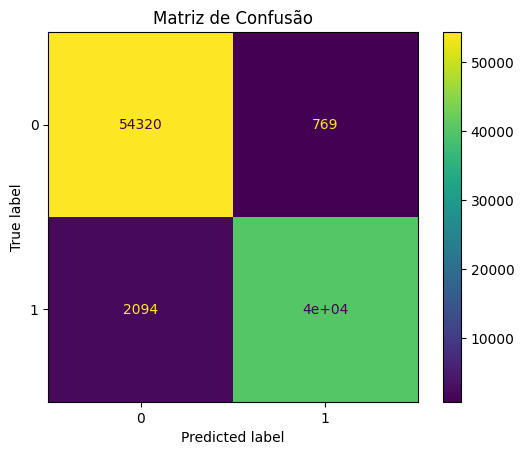

 
---------------- Métricas de Teste ----------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     18363
           1       0.97      0.94      0.95     14107

    accuracy                           0.96     32470
   macro avg       0.96      0.96      0.96     32470
weighted avg       0.96      0.96      0.96     32470



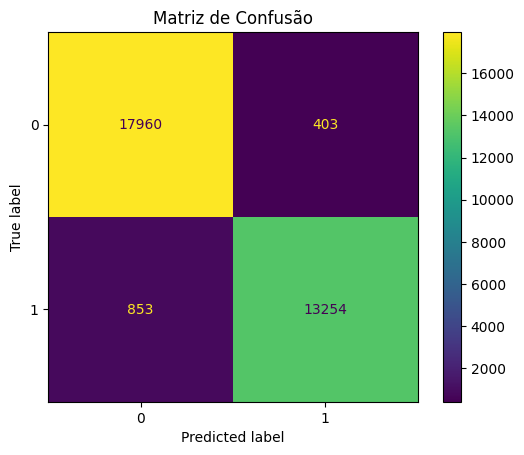

In [ ]:
melhor_modelo = rf_search.best_estimator_
mostrarMetricas(melhor_modelo)

Verificando a relevância de cada variável (feature importance) na previsão da resposta final.

Text(0.5, 1.0, 'Feature Importance')

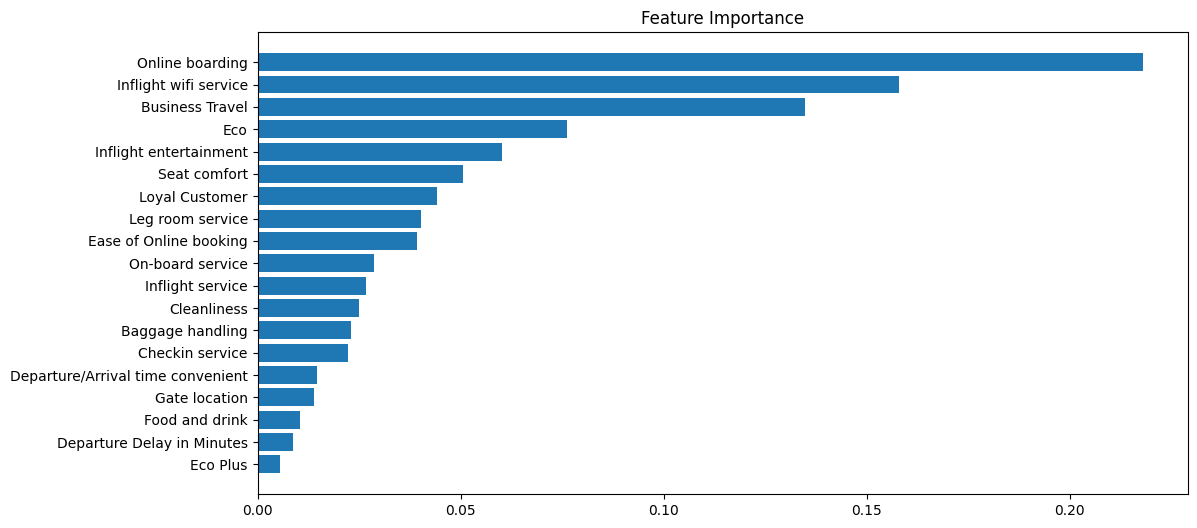

In [ ]:
estimator = melhor_modelo.named_steps['model']
feature_importance = estimator.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

O Random Forest apresentou um F1-Score de 97% no treino e 96% no teste, similar ao XGBoost. Este modelo também demonstrou boa capacidade de generalização, com desempenho consistente entre treino e teste. As três variáveis mais relevantes são as mesmas do XGBoost, embora em uma ordem distinta de importância. Online Boarding continua sendo a variável mais relevante para determinar a satisfação dos passageiros.

## Resultados

- Os métodos ensemble (XGBoost e Random Forest) superaram os classificadores únicos (Regressão Logística e kNN) em termos de performance e estabilidade entre os conjuntos de treino e teste. A Regressão Logística, embora simples e interpretável, teve uma performance inferior. O kNN mostrou sinais claros de overfitting, com métricas perfeitas no conjunto de treino, mas queda no conjunto de testes.

- Os métodos Ensemble, ao combinar múltiplos preditores e reduzir o risco de overfitting, exibiram um desempenho mais robusto e preciso. Entre os Ensembles, tanto XGBoost quanto Random Forest apresentaram performance semelhante e superior aos classificadores únicos.

- Portanto, para este problema, conclui-se que os métodos Ensemble possuem melhor performance e capacidade de generalização em comparação com os classificadores únicos testados.